# **Model Version: 0.1**


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ***Imports***

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import os
import numpy as np
import librosa
import random
from torch.utils.data import DataLoader
from torch import optim
import argparse
from sklearn.metrics import accuracy_score

### **Models**

In [4]:
class TDNN(nn.Module):
    
    def __init__(
                    self, 
                    input_dim=23, 
                    output_dim=512,
                    context_size=5,
                    stride=1,
                    dilation=1,
                    batch_norm=False,
                    dropout_p=0.2
                ):
        '''
        TDNN as defined by https://www.danielpovey.com/files/2015_interspeech_multisplice.pdf

        Affine transformation not applied globally to all frames but smaller windows with local context

        batch_norm: True to include batch normalisation after the non linearity
        
        Context size and dilation determine the frames selected
        (although context size is not really defined in the traditional sense)
        For example:
            context size 5 and dilation 1 is equivalent to [-2,-1,0,1,2]
            context size 3 and dilation 2 is equivalent to [-2, 0, 2]
            context size 1 and dilation 1 is equivalent to [0]
        '''
        super(TDNN, self).__init__()
        self.context_size = context_size
        self.stride = stride
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dilation = dilation
        self.dropout_p = dropout_p
        self.batch_norm = batch_norm
      
        self.kernel = nn.Linear(input_dim*context_size, output_dim)
        self.nonlinearity = nn.ReLU()
        if self.batch_norm:
            self.bn = nn.BatchNorm1d(output_dim)
        if self.dropout_p:
            self.drop = nn.Dropout(p=self.dropout_p)
        
    def forward(self, x):
        '''
        input: size (batch, seq_len, input_features)
        outpu: size (batch, new_seq_len, output_features)
        '''
        
        _, _, d = x.shape
        assert (d == self.input_dim), 'Input dimension was wrong. Expected ({}), got ({})'.format(self.input_dim, d)
        x = x.unsqueeze(1)

        # Unfold input into smaller temporal contexts
        x = F.unfold(
                        x, 
                        (self.context_size, self.input_dim), 
                        stride=(1,self.input_dim), 
                        dilation=(self.dilation,1)
                    )

        # N, output_dim*context_size, new_t = x.shape
        x = x.transpose(1,2)
        x = self.kernel(x.float())
        x = self.nonlinearity(x)
        
        if self.dropout_p:
            x = self.drop(x)

        if self.batch_norm:
            x = x.transpose(1,2)
            x = self.bn(x)
            x = x.transpose(1,2)

        return x

In [5]:
class X_vector(nn.Module):
    def __init__(self, input_dim = 40, num_classes=10):
        super(X_vector, self).__init__()
        self.tdnn1 = TDNN(input_dim=input_dim, output_dim=1280, context_size=3, dilation=2,dropout_p=0.5)
        self.tdnn2 = TDNN(input_dim=1280, output_dim=1280, context_size=1, dilation=1,dropout_p=0.5)
        self.tdnn3 = TDNN(input_dim=1280, output_dim=1024, context_size=5, dilation=2,dropout_p=0.5)
        self.tdnn4 = TDNN(input_dim=1024, output_dim=1024, context_size=1, dilation=1,dropout_p=0.5)
        self.tdnn5 = TDNN(input_dim=1024, output_dim=768, context_size=2, dilation=1,dropout_p=0.5)
        self.tdnn6 = TDNN(input_dim=768, output_dim=512, context_size=1, dilation=1,dropout_p=0.5)
        self.tdnn7 = TDNN(input_dim=512, output_dim=256, context_size=1, dilation=3,dropout_p=0.5)
        #### Frame levelPooling
        self.segment8 = nn.Linear(512, 512)
        self.segment9 = nn.Linear(512, 512)
        self.output = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, inputs):
        tdnn1_out = self.tdnn1(inputs)
        return tdnn1_out
        tdnn2_out = self.tdnn2(tdnn1_out)
        tdnn3_out = self.tdnn3(tdnn2_out)
        tdnn4_out = self.tdnn4(tdnn3_out)
        tdnn5_out = self.tdnn5(tdnn4_out)
        tdnn6_out = self.tdnn6(tdnn5_out)
        tdnn7_out = self.tdnn7(tdnn6_out)
        ### Stat Pool
        mean = torch.mean(tdnn7_out,1)
        std = torch.std(tdnn7_out,1)
        stat_pooling = torch.cat((mean,std),1)
        segment8_out = self.segment8(stat_pooling)
        x_vec = self.segment9(segment8_out)
        predictions = self.softmax(self.output(x_vec))
        return predictions,x_vec

In [6]:
class X_vector(nn.Module):
    def __init__(self, input_dim = 40, num_classes=10):
        super(X_vector, self).__init__()
        self.tdnn1 = TDNN(input_dim=input_dim, output_dim=1280, context_size=3, dilation=2,dropout_p=0.5)
        self.tdnn2 = TDNN(input_dim=1280, output_dim=1280, context_size=1, dilation=1,dropout_p=0.5)
        self.tdnn3 = TDNN(input_dim=1280, output_dim=1024, context_size=5, dilation=2,dropout_p=0.5)
        self.tdnn4 = TDNN(input_dim=1024, output_dim=1024, context_size=1, dilation=1,dropout_p=0.5)
        self.tdnn5 = TDNN(input_dim=1024, output_dim=768, context_size=2, dilation=1,dropout_p=0.5)
        self.tdnn6 = TDNN(input_dim=768, output_dim=512, context_size=1, dilation=1,dropout_p=0.5)
        self.tdnn7 = TDNN(input_dim=512, output_dim=256, context_size=1, dilation=3,dropout_p=0.5)
        #### Frame levelPooling
        self.segment8 = nn.Linear(512, 512)
        self.segment9 = nn.Linear(512, 512)
        self.output = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, inputs):
        tdnn1_out = self.tdnn1(inputs)
        tdnn2_out = self.tdnn2(tdnn1_out)
        tdnn3_out = self.tdnn3(tdnn2_out)
        tdnn4_out = self.tdnn4(tdnn3_out)
        tdnn5_out = self.tdnn5(tdnn4_out)
        tdnn6_out = self.tdnn6(tdnn5_out)
        tdnn7_out = self.tdnn7(tdnn6_out)
        ### Stat Pool
        
        mean = torch.mean(tdnn7_out,1)
        std = torch.std(tdnn7_out,1)
        stat_pooling = torch.cat((mean,std),1)
        segment8_out = self.segment8(stat_pooling)
        x_vec = self.segment9(segment8_out)
        predictions = self.output(x_vec)
        return predictions,x_vec

### Utiles 

In [9]:
def load_wav(audio_filepath, sr, min_dur_sec=4):
    audio_data,fs  = librosa.load(audio_filepath,sr=16000)
    len_file = len(audio_data)
    
    if len_file <int(min_dur_sec*sr):
        dummy=np.zeros((1,int(min_dur_sec*sr)-len_file))
        extened_wav = np.concatenate((audio_data,dummy[0]))
    else:
        
        extened_wav = audio_data
    return extened_wav


def lin_mel_from_wav(wav, hop_length, win_length, n_mels):
    linear = librosa.feature.melspectrogram(wav, n_mels=n_mels, win_length=win_length, hop_length=hop_length) # linear spectrogram
    return linear.T

def lin_spectogram_from_wav(wav, hop_length, win_length, n_fft=512):
    linear = librosa.stft(wav, n_fft=n_fft, win_length=win_length, hop_length=hop_length) # linear spectrogram
    return linear.T


def feature_extraction(filepath,sr=16000, min_dur_sec=4,win_length=400,hop_length=160, n_mels=40, spec_len=400,mode='train'):
    audio_data = load_wav(filepath, sr=sr,min_dur_sec=min_dur_sec)
    linear_spect = lin_spectogram_from_wav(audio_data, hop_length, win_length, n_fft=512)
    mag, _ = librosa.magphase(linear_spect)  # magnitude
    mag_T = mag.T
    mu = np.mean(mag_T, 0, keepdims=True)
    std = np.std(mag_T, 0, keepdims=True)
    return (mag_T - mu) / (std + 1e-5)
    
    
    
    
def load_data(filepath,sr=16000, min_dur_sec=4,win_length=400,hop_length=160, n_mels=40, spec_len=400,mode='train'):
    audio_data = load_wav(filepath, sr=sr,min_dur_sec=min_dur_sec)
    #linear_spect = lin_spectogram_from_wav(audio_data, hop_length, win_length, n_mels)
    linear_spect = lin_spectogram_from_wav(audio_data, hop_length, win_length, n_fft=512)
    mag, _ = librosa.magphase(linear_spect)  # magnitude
    mag_T = mag.T
    
    if mode=='train':
        randtime = np.random.randint(0, mag_T.shape[1]-spec_len)
        spec_mag = mag_T[:, randtime:randtime+spec_len]
    else:
        spec_mag = mag_T
    
    # preprocessing, subtract mean, divided by time-wise var
    mu = np.mean(spec_mag, 0, keepdims=True)
    std = np.std(spec_mag, 0, keepdims=True)
    return (spec_mag - mu) / (std + 1e-5)
    


def load_npy_data(filepath,spec_len=400,mode='train'):
    mag_T = np.load(filepath)
    if mode=='train':
        randtime = np.random.randint(0, mag_T.shape[1]-spec_len)
        spec_mag = mag_T[:, randtime:randtime+spec_len]
    else:
        spec_mag = mag_T
    return spec_mag
    
    



def speech_collate(batch):
    targets = []
    specs = []
    for sample in batch:
        specs.append(sample['features'])
        targets.append((sample['labels']))
    return specs, targets

## SpeechDataGenerator

In [10]:
class SpeechDataGenerator():
    """Speech dataset."""

    def __init__(self, manifest, mode='train'):
        """
        Read the textfile and get the paths
        """
        
        # [line.rstrip('\n').split(' ')[0]
        self.mode=mode
        self.audio_links = [" ".join(line.rstrip('\n').split(' ')[:-1]) for line in open(manifest)]
        self.labels = [int(line.rstrip('\n').split(' ')[-1]) for line in open(manifest)]
        

    def __len__(self):
        return len(self.audio_links)

    def __getitem__(self, idx):
        audio_link =self.audio_links[idx]
        class_id = self.labels[idx]
        #lang_label=lang_id[self.audio_links[idx].split('/')[-2]]
        spec = load_data(audio_link,mode=self.mode)
        sample = {'features': torch.from_numpy(np.ascontiguousarray(spec)), 'labels': torch.from_numpy(np.ascontiguousarray(class_id))}
        return sample

## Train X Vector

In [11]:
torch.multiprocessing.set_sharing_strategy('file_system')

########## Argument parser

training_filepath = '/content/drive/My Drive/10_lang_wav_files/train_10_lang.txt'
testing_filepath = '/content/drive/My Drive/10_lang_wav_files/test_10_lang.txt'
validation_filepath = '/content/drive/My Drive/10_lang_wav_files/validation_10_lang.txt'
input_dim = 257
num_classes = 10
lamda_val = 0.5
batch_size = 100
use_gpu = True
num_epochs = 100

### Data related
dataset_train = SpeechDataGenerator(manifest=training_filepath, mode='train')
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=speech_collate)

dataset_val = SpeechDataGenerator(manifest=validation_filepath, mode='train')
dataloader_val = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=speech_collate)

dataset_test = SpeechDataGenerator(manifest=testing_filepath, mode='test')
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=speech_collate)

## Model related
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = X_vector(input_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0, betas=(0.9, 0.98), eps=1e-9)
loss_fun = nn.CrossEntropyLoss()


def train(dataloader_train, epoch):
    train_loss_list = []
    full_preds = []
    full_gts = []
    model.train()

    print("batch: ")
    for i_batch, sample_batched in enumerate(dataloader_train):
        print(str(i_batch+1)+" ", end='')

        features = torch.from_numpy(np.asarray([torch_tensor.numpy().T for torch_tensor in sample_batched[0]])).float()
        labels = torch.from_numpy(np.asarray([torch_tensor[0].numpy() for torch_tensor in sample_batched[1]]))
        labels = labels.long()
        features, labels = features.to(device), labels.to(device)
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits, x_vec = model(features)
        #### CE loss
        loss = loss_fun(pred_logits, labels)
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
        # train_acc_list.append(accuracy)
        # if i_batch%10==0:
        #    print('Loss {} after {} iteration'.format(np.mean(np.asarray(train_loss_list)),i_batch))

        predictions = np.argmax(pred_logits.detach().cpu().numpy(), axis=1)
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)

    mean_acc = accuracy_score(full_gts, full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss, mean_acc, epoch))

    folder_path = '/content/drive/My Drive/saved_models'
    model_save_path = f'{folder_path}/saved_model_{i_batch}.pth'
    state_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': num_epochs
    }
    torch.save(state_dict, model_save_path)


def validation(dataloader_val, epoch):
    model.eval()
    with torch.no_grad():
        val_loss_list = []
        full_preds = []
        full_gts = []
        for i_batch, sample_batched in enumerate(dataloader_val):
            features = torch.from_numpy(
                np.asarray([torch_tensor.numpy().T for torch_tensor in sample_batched[0]])).float()
            labels = torch.from_numpy(np.asarray([torch_tensor[0].numpy() for torch_tensor in sample_batched[1]]))
            labels = labels.long()
            features, labels = features.to(device), labels.to(device)
            pred_logits, x_vec = model(features)
            #### CE loss
            loss = loss_fun(pred_logits, labels)
            val_loss_list.append(loss.item())
            # train_acc_list.append(accuracy)
            predictions = np.argmax(pred_logits.detach().cpu().numpy(), axis=1)
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)

        mean_acc = accuracy_score(full_gts, full_preds)
        mean_loss = np.mean(np.asarray(val_loss_list))
        print('Total validation loss {} and Validation accuracy {} after {} epochs'.format(mean_loss, mean_acc, epoch))

In [ ]:
model_save_path = '/content/drive/My Drive/saved_model_97acc.pth'
state_dict = torch.load(model_save_path)
model.load_state_dict(state_dict['model'])
optimizer.load_state_dict(state_dict['optimizer'])
epoch = state_dict['epoch']

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def test_1_file(dataloader_val, epoch=0):
    model.eval()
    with torch.no_grad():
        val_loss_list = []
        full_preds = []
        full_gts = []
        for i_batch, sample_batched in enumerate(dataloader_val):
            features = torch.from_numpy(
                np.asarray([torch_tensor.numpy().T for torch_tensor in sample_batched[0]])).float()
            labels = torch.from_numpy(np.asarray([torch_tensor[0].numpy() for torch_tensor in sample_batched[1]]))
            labels = labels.long()
            features, labels = features.to(device), labels.to(device)
            pred_logits, x_vec = model(features)
            #### CE loss
            loss = loss_fun(pred_logits, labels)
            val_loss_list.append(loss.item())
            # train_acc_list.append(accuracy)
            predictions = np.argmax(pred_logits.detach().cpu().numpy(), axis=1)
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)

        mean_acc = accuracy_score(full_gts, full_preds)
        mean_loss = np.mean(np.asarray(val_loss_list))
        
        # Confusion matrix
        cm = confusion_matrix(full_gts, full_preds)
        
        # Accuracy for each class
        class_acc = cm.diagonal() / cm.sum(axis=1)
        class_names = ['Arabic', 'Spanish', 'Farsi', 'France', 'Hausa', 'Italian', 'Japanese', 'Russian', 'Thai', 'Chinese']
        
        # Recall, Precision, and F1 scores
        recall = recall_score(full_gts, full_preds, average='macro')
        precision = precision_score(full_gts, full_preds, average='macro')
        f1 = f1_score(full_gts, full_preds, average='macro')
        
        # Convert confusion matrix values to percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Heatmap of confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_percent, annot=True, fmt=".3f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


In [12]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
from google.colab import files
import os
from pydub import AudioSegment
from google.colab import drive

def convert_mp3_to_wav(file_path):
    sound = AudioSegment.from_mp3(file_path)
    fname_without_ext = os.path.splitext(file_path)[0]
    wav_path = f"{fname_without_ext}.wav"
    sound.export(wav_path, format="wav")
    # os.remove(file_path)
    return wav_path

In [29]:
wav_filename = convert_mp3_to_wav('/content/drive/My Drive/file_name.mp3')

# Define the destination folder in Google Drive
drive_folder = '/content/drive/My Drive/'

# Save the WAV file to the specified folder in Google Drive
destination_path = os.path.join(drive_folder, wav_filename)
os.rename(wav_filename, destination_path)

label = input("Enter label [0-9]: ")

print('File saved to Google Drive:', destination_path)

# Create a text file containing the path of the saved WAV file
text_filename = 'test_1_wav_file.txt'
text_content = f'{destination_path} {label}'

# Define the destination path for the text file
text_destination_path = os.path.join(drive_folder, text_filename)

# Write the content to the text file
with open(text_destination_path, 'w') as file:
    file.write(text_content)

print('Text file saved to Google Drive:', text_destination_path)

Enter label [0-9]: 0
File saved to Google Drive: /content/drive/My Drive/common_voice_ar_35760586.wav
Text file saved to Google Drive: /content/drive/My Drive/test_1_wav_file.txt


<ipython-input-22-a9580e1571ff>:35: RuntimeWarning: invalid value encountered in true_divide
  class_acc = cm.diagonal() / cm.sum(axis=1)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-22-a9580e1571ff>:44: RuntimeWarning: invalid value encountered in true_divide
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


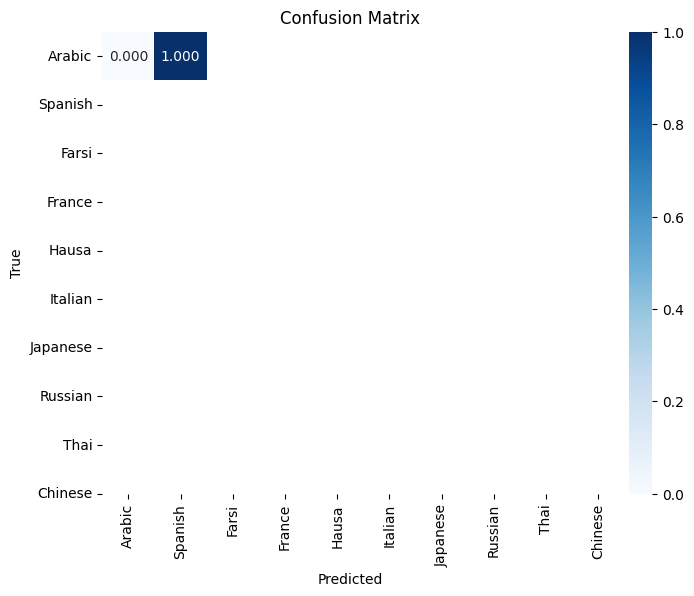

In [30]:
batch_size = 1

test_filepath = '/content/drive/My Drive/test_1_wav_file.txt'
dataset_test = SpeechDataGenerator(manifest=test_filepath)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=speech_collate)
test_1_file(dataloader_test)